In [618]:
import functools
import importlib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from bullinger import chronogram
from bullinger import cohort
from bullinger import intervals
from bullinger import plot
from bullinger import video
from bullinger import analysis

intervals = importlib.reload(intervals)
video = importlib.reload(video)
chronogram = importlib.reload(chronogram)
cohort = importlib.reload(cohort)
plot = importlib.reload(plot)
analysis = importlib.reload(analysis)

In [619]:
folder = '/home/olivier/dev/data/laura_codage/'
c = cohort.Cohort(folder, num_workers=20)

In [620]:
print(c.num_annotations, 'annotations in', len(c), 'videos' )

3320 annotations in 196 videos


In [521]:
c.summary

video_id  baby  duration
semester group                          
1.0      AD           52    10  5366.159
         TD           49    10  4726.794
2.0      AD           46    10  4780.752
         TD           47    10  3844.420

array(['parle', 'init', 'mama', 'rep', 'touch', 'sons', 'chant', 'obj',
       'voc'], dtype=object)

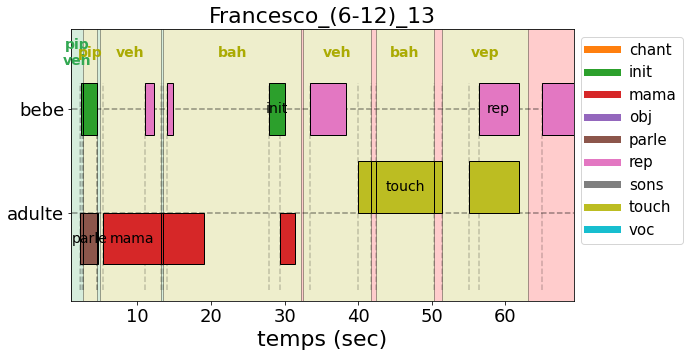

In [328]:
chronogram = importlib.reload(chronogram)
chronogram.plot(c[0], tags=c.interaction_tags)
c.actors_df.tag.unique()


# Comment les bébés sont-ils stimulés et comment répondent-ils ?

In [329]:
df = c.aggregate(lambda v: v.summary)
df

duration           stimulation            response          
                      mean       sem        mean       sem      mean       sem
semester group                                                                
1.0      AD     101.849635  4.263168    0.441683  0.040955  0.149508  0.027654
         TD      93.470220  3.917274    0.520146  0.040161  0.310798  0.046116
2.0      AD     100.790000  4.464595    0.496069  0.048292  0.211734  0.032572
         TD      81.190894  3.649250    0.547248  0.044832  0.449333  0.047502

<AxesSubplot:title={'center':'response'}, xlabel='semester', ylabel='response'>

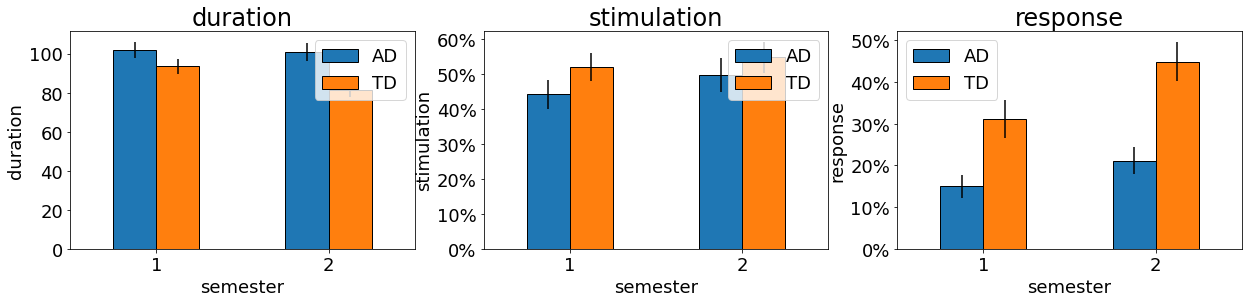

In [233]:
fig, axes = plt.subplots(1, 3, figsize=(21, 4))
plot.plot_agg(df, metric='duration', ax=axes[0], rot=0)
plot.plot_agg(df, metric='stimulation', ax=axes[1], rot=0)
plot.plot_agg(df, metric='response', ax=axes[2], rot=0)

# Le nombre d'appuis influencent-ils la reponse du bébé ?

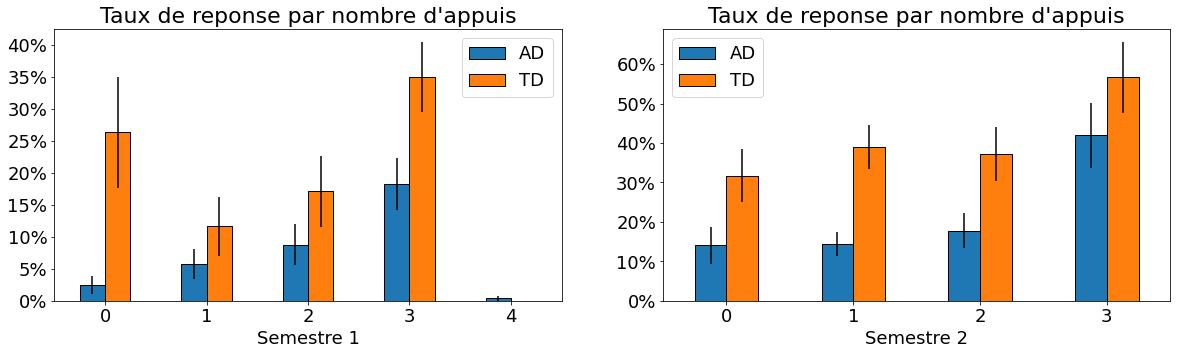

In [537]:
_, axes = plt.subplots(1, 2, figsize=(20, 5))
axes = plot.per_semester(c.aggregate(analysis.duration_per_supports), axes=axes, rot=0)
for ax in axes:
    ax.set_title('Taux de reponse par nombre d\'appuis', fontsize=22)
    

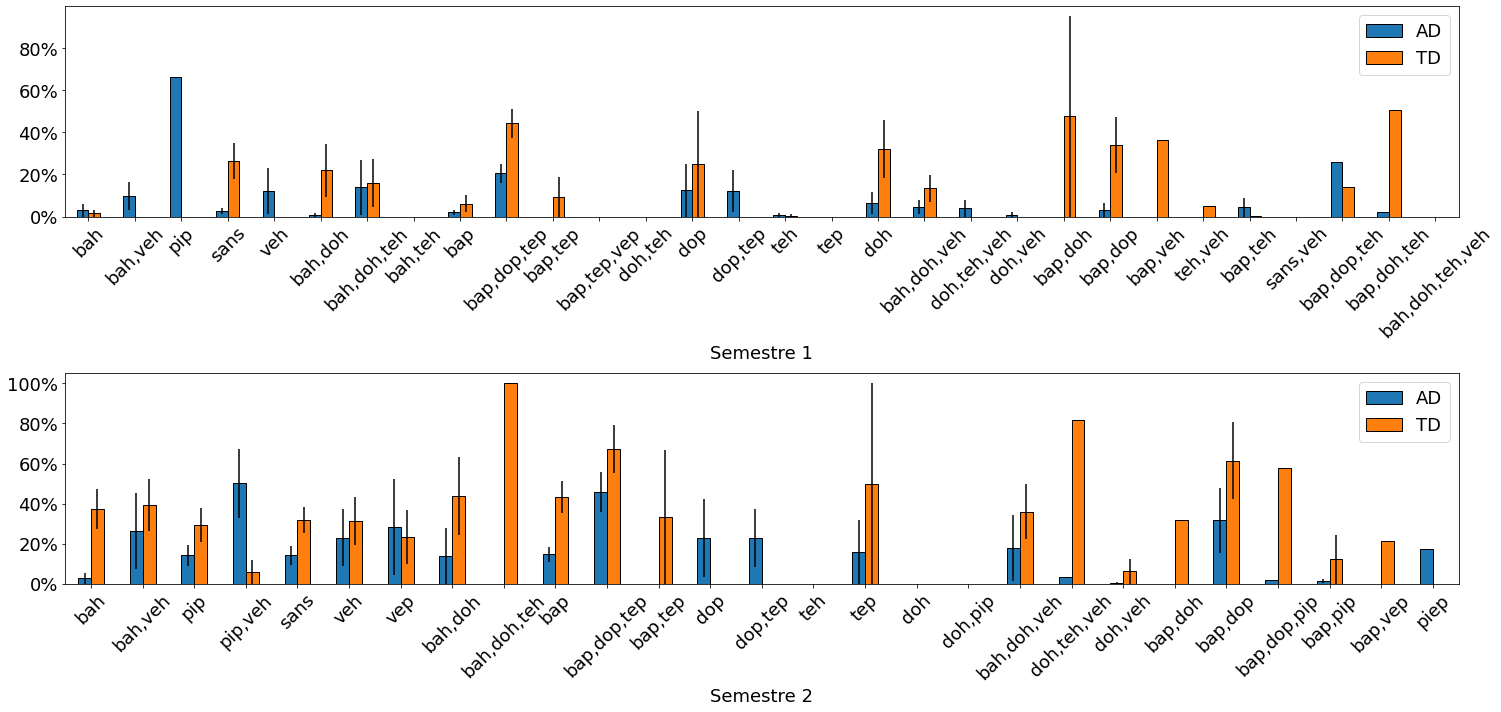

In [111]:
def full_supports_fn(v):
    return pd.pivot_table(v.responses_per(groupby='context'), 'relative', index='context').transpose().iloc[0]

df = c.aggregate(full_supports_fn).dropna(axis=1)
fig, axes = plt.subplots(2, 1, figsize=(21, 10))
plot.per_semester(df, axes=axes, rot=45)
plt.tight_layout()

# Les bebes AD sont-ils moins filmes ?

<AxesSubplot:title={'center':'Le bébé est hors champ'}, xlabel='semester', ylabel='invisible'>

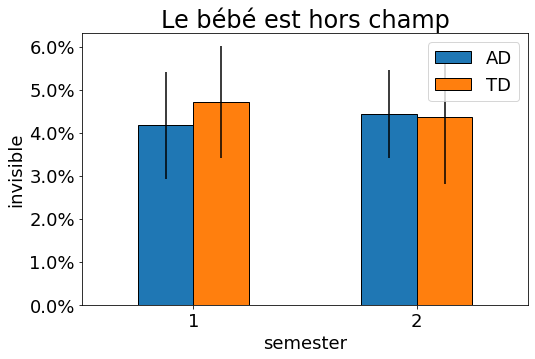

In [594]:
plot.plot_agg(c.aggregate(analysis.invisible_time), 'invisible', rot=0, title='Le bébé est hors champ')

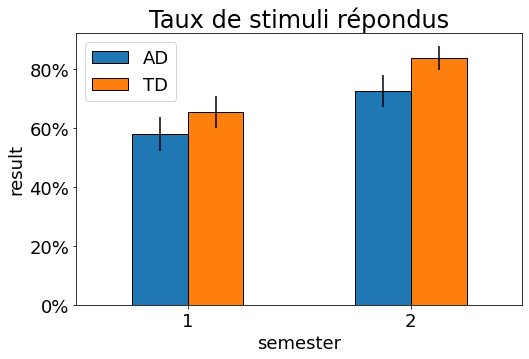

In [591]:
agg_df = c.aggregate(functools.partial(analysis.response_rate, tolerance=5))
ax = plot.plot_agg(agg_df, 'result', rot=0, title='Taux de stimuli répondus')

4 sequences d'interaction


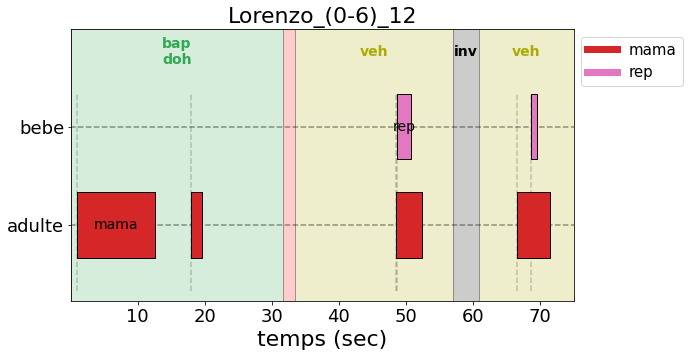

In [607]:
chronogram.plot(c[9])
print(len(c[9].sequences(tolerance=5)), 'sequences d\'interaction')


<AxesSubplot:title={'center':'Durée corrigée relative de réponse'}, xlabel='semester', ylabel='result'>

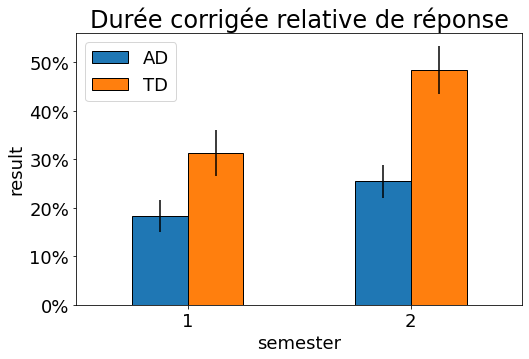

In [608]:
df = c.aggregate(functools.partial(analysis.fair_relative_duration, offset=5))
plot.plot_agg(df, 'result', rot=0, title='Durée corrigée relative de réponse')

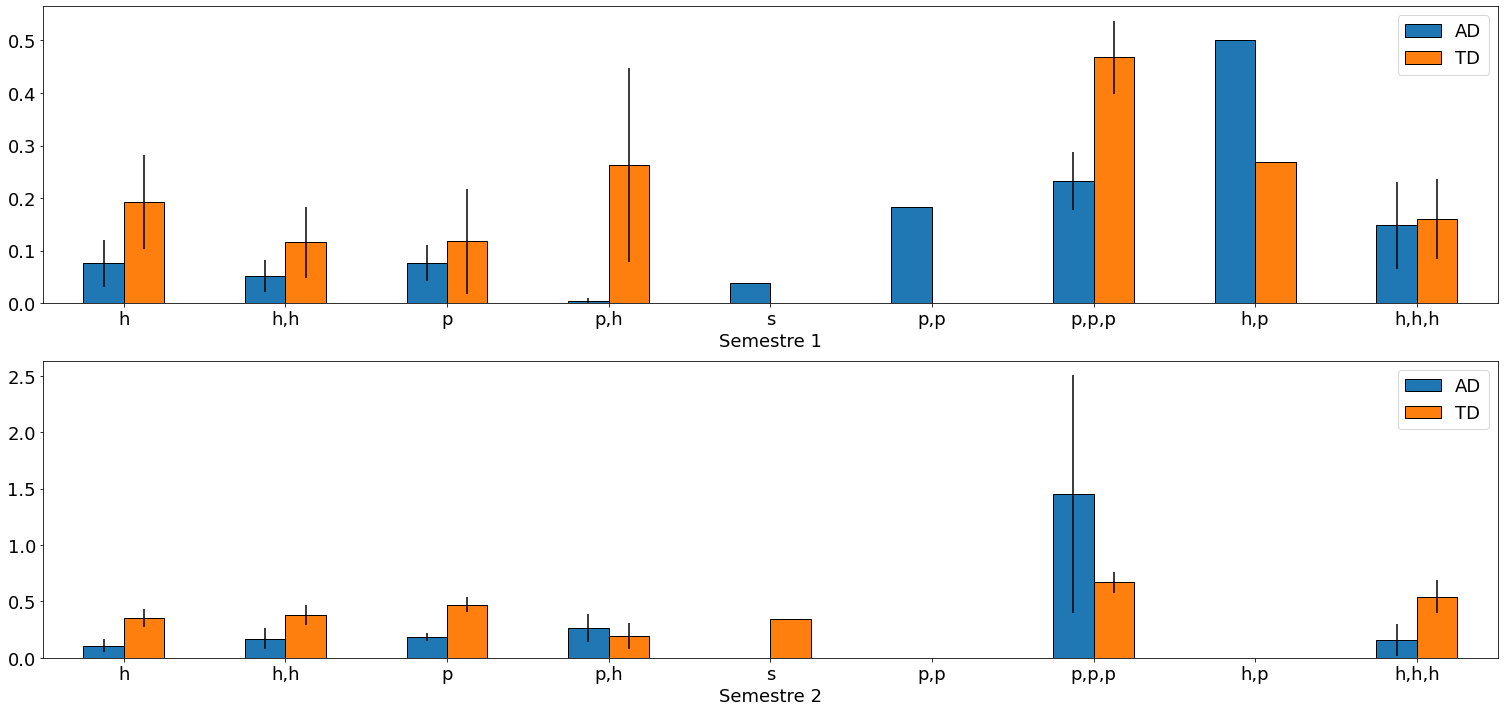

In [268]:
def support_type_fn(v):
    v.df['support_type'] = v.df.context.apply(lambda x: ','.join(a[-1] for a in x.split(',')))
    return pd.pivot_table(
        v.responses_per(groupby='support_type'), 'relative', index='support_type').transpose().iloc[0]

df = c.aggregate(support_type_fn).dropna(axis=1)
fig, axes = plt.subplots(2, 1, figsize=(21, 10))
plot.plot_per_semester(df, axes=axes, rot=0)
plt.tight_layout()

# Le bébé est-il à l'initiative de l'interaction ?

<AxesSubplot:title={'center':"Le bébé initialise l'interaction"}, xlabel='semester', ylabel='result'>

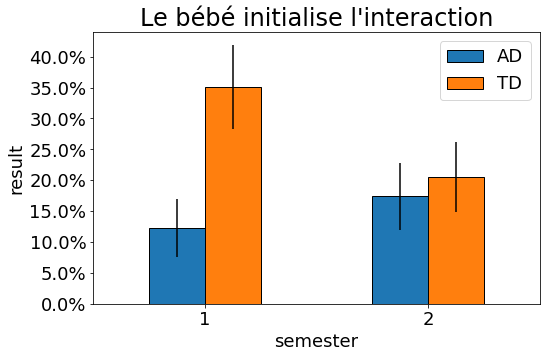

In [588]:
df = c.aggregate(functools.partial(analysis.starts, tolerance=5))
plot.plot_agg(df, 'result', rot=0, title='Le bébé initialise l\'interaction')

# Tour de parole

<AxesSubplot:title={'center':'Nombre de tour de paroles'}, xlabel='semester', ylabel='result'>

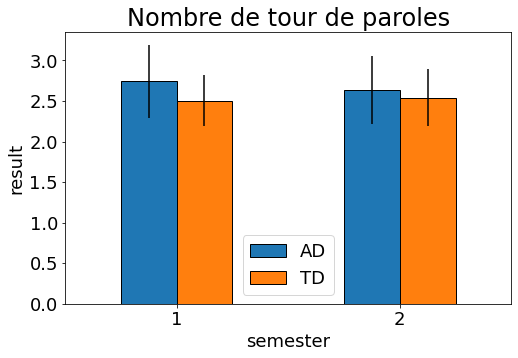

In [600]:
analysis = importlib.reload(analysis)
df = c.aggregate(functools.partial(analysis.turn_taking, tolerance=5))
plot.plot_agg(df, 'result', rot=0, title='Nombre de tour de paroles')

# Duree des reponses

<AxesSubplot:title={'center':'Durée moyenne des réponses'}, xlabel='semester', ylabel='result'>

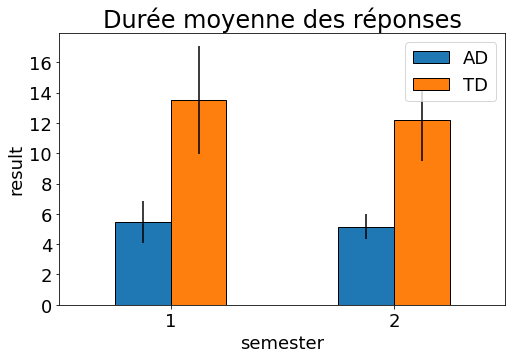

In [609]:
analysis = importlib.reload(analysis)
df = c.aggregate(analysis.average_response_duration)
plot.plot_agg(df, 'result', rot=0, title='Durée moyenne des réponses')

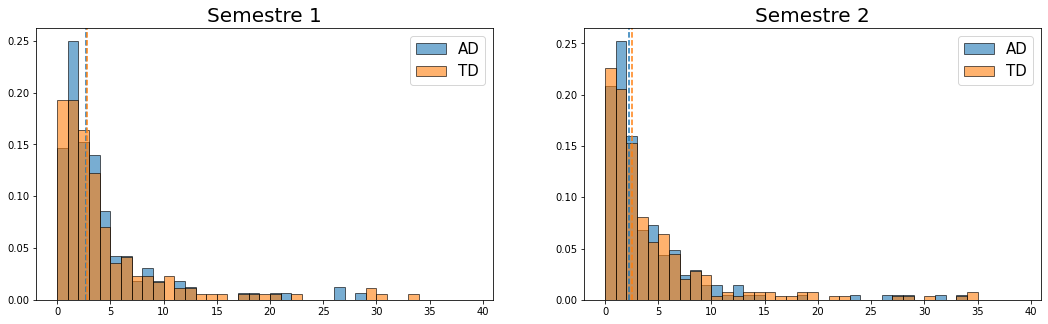

In [686]:
cmap = plt.get_cmap('tab10')
s = 2
max_duration = 100
_, axes = plt.subplots(1, 2, figsize=(18, 5))
for ax, s in zip(axes, [1, 2]):
    sub_df = df[(df.semester == s) & (df.duration < max_duration)]
    for i, group in enumerate(['AD', 'TD']):
        values = sub_df[sub_df.group == group].duration
        ax.hist(values, density=True, bins=np.arange(40),
                label=group, color=cmap(0.1*i), ec='k', alpha=0.6)
        ax.axvline(values.median(), linestyle='--', color=cmap(0.1*i))
    ax.legend(fontsize=15)
    ax.set_title(f'Semestre {s}', fontsize=20)

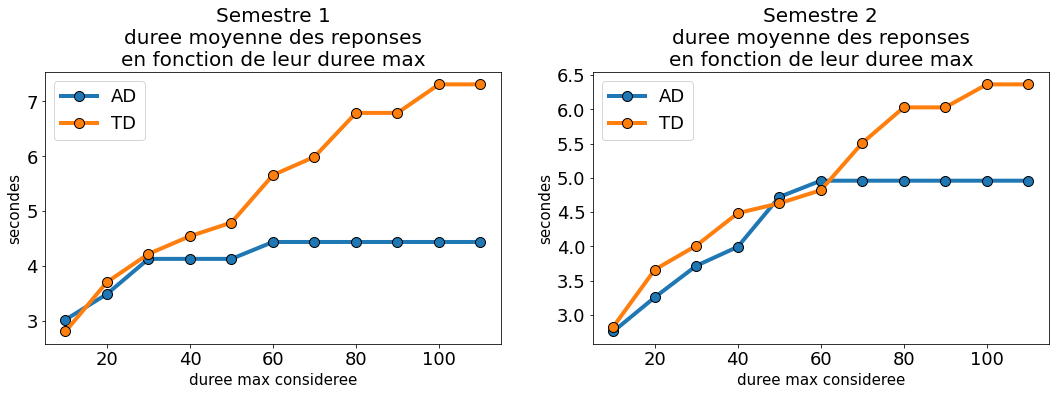

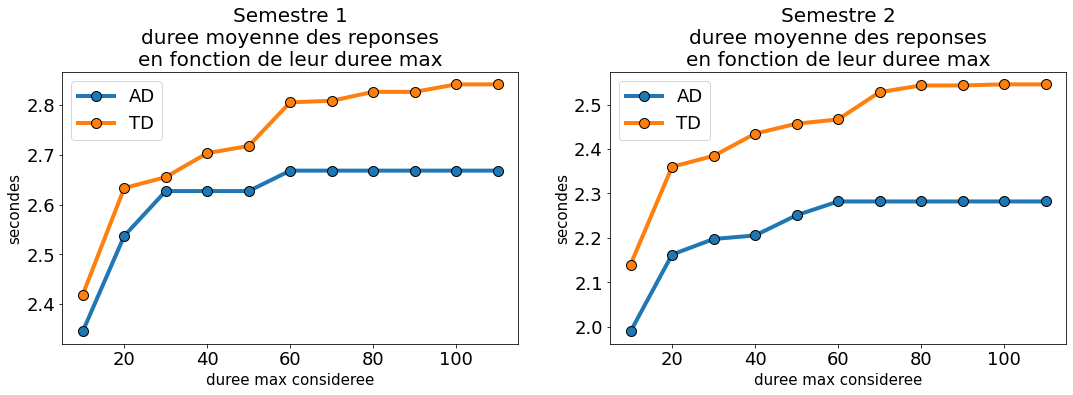

In [688]:
def plot_mean_duration_evolution(c, agg_func=np.mean):
    df = c.responses
    cmap = plt.get_cmap('tab10')
    _, axes = plt.subplots(1, 2, figsize=(18, 5))
    for ax, s in zip(axes, [1, 2]):
        for i, group in enumerate(['AD', 'TD']):
            values = []
            sub_df = df[(df.group == group) & (df.semester == s)]
            thresholds = np.arange(10, 120, 10)
            for max_duration in thresholds:
                durations = sub_df[sub_df.duration < max_duration].duration
                values.append(agg_func(durations))
            ax.plot(thresholds, values, label=group,
                    lw=4, marker='o', markersize=10, markeredgecolor='k', color=cmap(0.1*i))
        ax.legend(fontsize=15)
        ax.set_title(f'Semestre {s}\nduree moyenne des reponses\nen fonction de leur duree max', fontsize=20)
        ax.set_ylabel("secondes",fontsize=15)
        ax.set_xlabel("duree max consideree",fontsize=15)
        plot.readable_ax(ax)
        
plot_mean_duration_evolution(c, agg_func=np.mean)
plot_mean_duration_evolution(c, agg_func=np.median)

# Le bebe commence l interaction mais on lui repond pas

<AxesSubplot:title={'center':'Interaction non repondue'}, xlabel='semester', ylabel='result'>

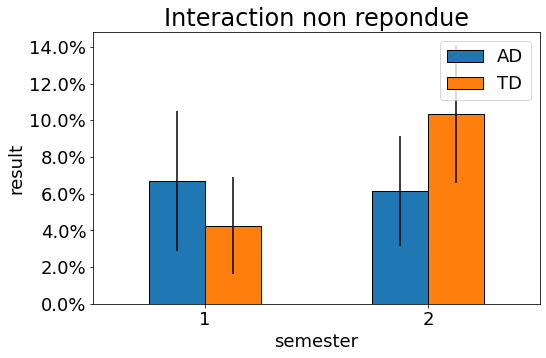

In [601]:
analysis = importlib.reload(analysis)
df = c.aggregate(functools.partial(analysis.unanswered_init, tolerance=5))
plot.plot_agg(df, 'result', rot=0, title='Interaction non repondue')

# Repeated movements

In [360]:
print(c.df[c.df.actor.str.startswith('rme')].video_id.unique().size, 'videos avec RME')

27 videos avec RME


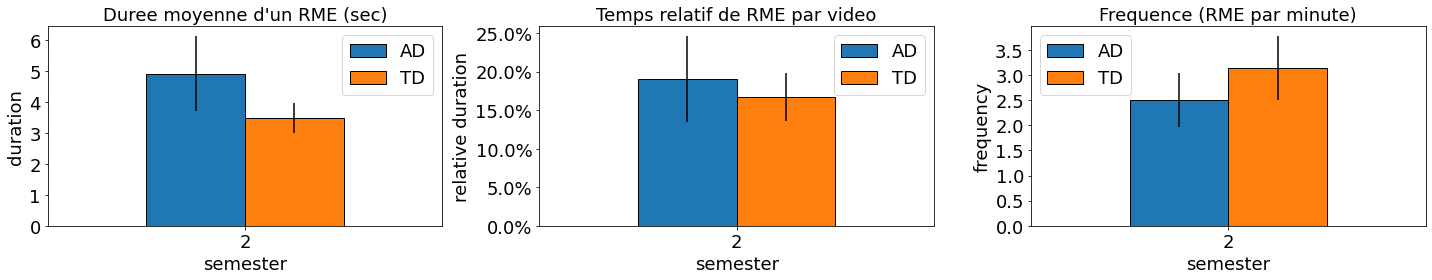

In [372]:
def repeated_duration(v: video.Video):
    df = v.df
    df = df[df.actor.str.startswith('rme')]
    exists = df.duration.sum() > 0
    return pd.Series({
        'duration': df.duration.mean(),
        'relative duration': df.duration.sum() / v.duration if exists else np.nan,
        'frequency': df.duration.count() / v.duration * 60 if exists else np.nan,
    })

df = c.aggregate(repeated_duration)
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
plot.plot_agg(df, 'duration', rot=0, ax=axes[0])
plot.plot_agg(df, 'relative duration', rot=0, ax=axes[1])
plot.plot_agg(df, 'frequency', rot=0, ax=axes[2], percentage=False)
axes[0].set_title('Duree moyenne d\'un RME (sec)', fontsize=18)
axes[1].set_title('Temps relatif de RME par video', fontsize=18)
axes[2].set_title('Frequence (RME par minute)', fontsize=18)
plt.tight_layout()

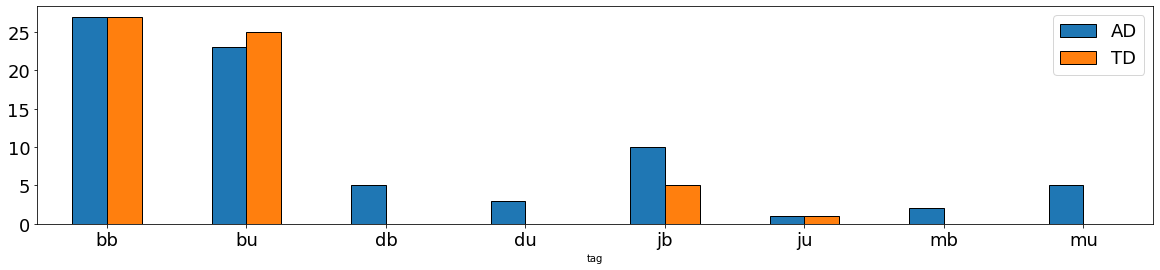

In [418]:
df = c.df[c.df.actor.str.startswith('rme')]
_, ax = plt.subplots(1, 1, figsize=(20, 4))
pd.pivot_table(df, 'duration', index='tag', columns=['group'], aggfunc='count').plot.bar(ec='k', ax=ax)
plot.readable_ax(ax)

<AxesSubplot:title={'center':'Claudio_(6-12)_09'}, xlabel='temps (sec)'>

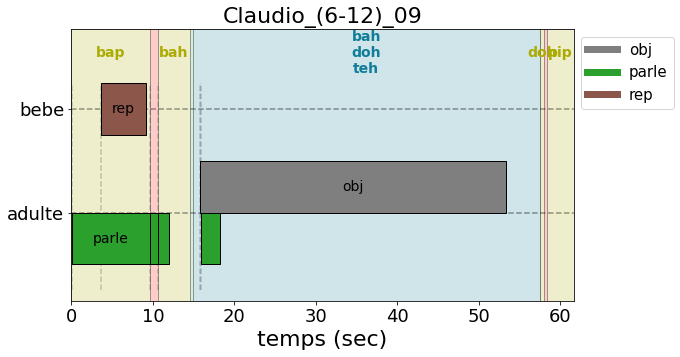

In [423]:
c.df[c.df.tag == 'db'].video_id.unique()
chronogram.plot(c['Claudio_(6-12)_09'])

In [402]:
def rme_breakdown(v):
    df = v.df
    return pd.pivot_table(df, 'duration', index='group', columns=['tag'], aggfunc=np.sum)

df = pd.concat([rme_breakdown(v) for v in c]).reset_index()
df.groupby('group').agg(['mean', 'sem'])

init                 mama                parle            \
           mean       sem       mean       sem       mean       sem   
group                                                                 
AD     5.889357  1.038983  29.422803  2.586733  21.938517  4.030469   
TD     6.210261  1.875960  26.046062  2.745201  19.203672  2.361504   

             rep              support            ...        db            \
            mean       sem       mean       sem  ...      mean       sem   
group                                            ...                       
AD     21.458608  2.416541  97.677949  2.907724  ...  11.06075  4.341101   
TD     33.461800  3.491652  84.560887  2.804284  ...       NaN       NaN   

           mb              du                 mu              voc      
         mean     sem    mean     sem       mean       sem   mean sem  
group                                                                  
AD     14.897  13.156  9.1685  4.3315  10.469667  3.751894  1.383 NaN  
TD        NaN     NaN     NaN     NaN        NaN       NaN    NaN NaN  

[2 rows x 40 columns]